In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

SRC_DATA_DIR = './source_data'
PR01_STAGEI_PABS_FEATS_FN = 'StageI-PR01_Absolute_Power_5min_windows.csv'
PR01_STAGEI_SYMPTOM_STATES_FN = 'StageI-PR01_Biomarker_Selected_Symptom_States.csv'
PR01_STAGEI_MODEL_PERF_FN = 'StageI-PR01_Biomarker_Model_Performance-Contacts_and_Band.txt'

In [2]:
def rkfold(X, y, n_feats=6, n_ite=200, n_splits=2):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = list()
    scores_shuffled = list()    
    top_feats = list()
    accuracy = list()
    accuracy_shuffled = list()
    df_roc = list()
    df_roc_shuffled = list()
    for iii in range(n_ite):
        for train_idx, test_idx in kfold.split(X, y):
            pipe = Pipeline([('norm', StandardScaler()),
                             ('fselect', SelectKBest(score_func=f_classif, k=n_feats)), 
                             ('logit', LogisticRegression(class_weight='balanced', solver='lbfgs'))]) 
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            probas = pipe.predict_proba(X.iloc[test_idx])
            preds = pipe.predict(X.iloc[test_idx])
            accuracy.append(accuracy_score(y.iloc[test_idx], preds))
            accuracy_shuffled.append(accuracy_score(y.iloc[test_idx], np.random.permutation(preds)))
            scores.append(roc_auc_score(y.iloc[test_idx], probas[:, 1]))
            scores_shuffled.append(roc_auc_score(y.iloc[test_idx], np.random.permutation(probas[:, 1])))  
            top_feats.extend(X.columns[pipe.named_steps['fselect'].get_support(indices=True)])
            
            tpr, fpr, _ = roc_curve(y.iloc[test_idx], probas[:, 1])
            df_roc.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))
            
            tpr, fpr, _ = roc_curve(y.iloc[test_idx], np.random.permutation(probas[:, 1]))
            df_roc_shuffled.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))
            
    df_roc = pd.concat(df_roc)
    df_roc_shuffled = pd.concat(df_roc_shuffled)    
    return scores, scores_shuffled, df_roc, df_roc_shuffled, accuracy, accuracy_shuffled, pd.value_counts(top_feats, normalize=False) / (n_ite * n_splits)

def fit_and_summary(X, y, outfn, n_feats=6):
    #X = X.apply(zscore)
     
    F, p = f_regression(X, y)
    feats = pd.Series(data=F, index=X.columns).sort_values(ascending=False)[:6].index   
    
    X2 = sm.add_constant(X[feats])
    fit = sm.Logit(y, X2).fit(disp=0)

    scores, scores_shuffled, curve, curve_shuffled, accuracy, accuracy_shuffled, top_feats = rkfold(X, y, n_feats)
    
    summary = fit.summary()
    auc_stats = pd.Series(scores).describe()
    auc_stats_shuffled = pd.Series(scores_shuffled).describe()    
    accuracy = pd.Series(accuracy).describe()    
    accuracy_shuffled = pd.Series(accuracy_shuffled).describe()        
    
    '''
    with open(outfn, 'w') as f:
        f.write('ROC AUC Stats from 1000 Randomly Sampled Models\n')
        f.write('----------------------------------------------\n')
        f.write(auc_stats.to_string() + '\n')
        f.write(summary.as_text())
    '''

    print('ROC AUC Stats from 1000 Randomly Sampled Models')
    print('----------------------------------------------')
    print(' ')
    print(auc_stats)
    
    print('Accuracy Stats from 1000 Randomly Sampled Models')
    print('----------------------------------------------')
    print(' ')
    print(accuracy)

    print(' ')
    print(summary)
    
    plt.figure()
    ax = plt.subplot(111)
    ax = sns.lineplot(x='tpr', y='fpr', data=curve.reset_index(), color='blue', linewidth=0.1, ax=ax);
    ax = sns.lineplot(x='tpr', y='fpr', data=curve_shuffled.reset_index(), color='gray', linewidth=0.1, ax=ax);    
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')    
    ax.set_xlim([0, 1]);
    ax.set_ylim([0, 1]);
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(['True: AUC={:0.2f}'.format(auc_stats['mean']),
               'Shuffled: AUC={:0.2f}'.format(auc_stats_shuffled['mean'])])
    sns.despine()
    plt.savefig('{}.pdf'.format(outfn), transparent=True)    
    plt.show()    
    
    return top_feats

# Load Features and Scores

In [3]:
SYMPTOM_STATES = pd.read_csv(os.path.join(SRC_DATA_DIR, PR01_STAGEI_SYMPTOM_STATES_FN), parse_dates=False)
PABS_FEAT = pd.read_csv(os.path.join(SRC_DATA_DIR, PR01_STAGEI_PABS_FEATS_FN), index_col=0)
PABS_FEAT.drop(['anx', 'nrg', 'dpr', 'ham'], axis=1, inplace=True)

In [4]:
SYMPTOM_STATES.index = SYMPTOM_STATES[SYMPTOM_STATES.columns[0]]

In [5]:
cdf = PABS_FEAT.loc[SYMPTOM_STATES.index]

## Summarize performance across 1000 randomly sampled models

ROC AUC Stats from 1000 Randomly Sampled Models
----------------------------------------------
 
count    400.000000
mean       0.783110
std        0.133366
min        0.181818
25%        0.700000
50%        0.803030
75%        0.883333
max        1.000000
dtype: float64
Accuracy Stats from 1000 Randomly Sampled Models
----------------------------------------------
 
count    400.000000
mean       0.738676
std        0.091275
min        0.352941
25%        0.705882
50%        0.764706
75%        0.823529
max        1.000000
dtype: float64
 
                           Logit Regression Results                           
Dep. Variable:                    1.0   No. Observations:                   34
Model:                          Logit   Df Residuals:                       27
Method:                           MLE   Df Model:                            6
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.4564
Time:                        11:57:24   Log-Likelihood:   

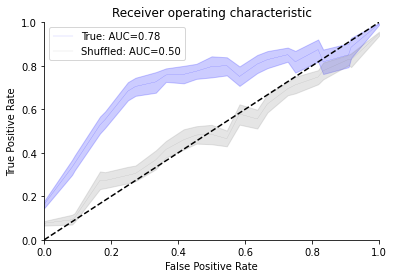

In [6]:
top_feats = fit_and_summary(cdf, SYMPTOM_STATES["1.0"], os.path.join(SRC_DATA_DIR, PR01_STAGEI_MODEL_PERF_FN))

## Frequency of feature selection across 1000 random models

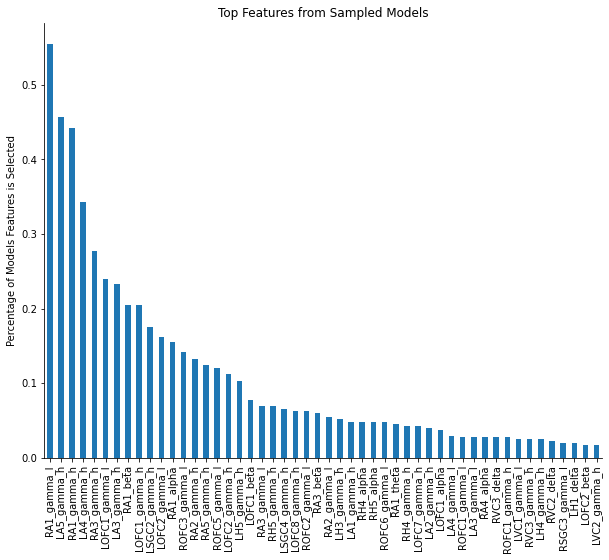

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
top_feats[:50].plot(kind='bar');
ax.set_ylabel('Percentage of Models Features is Selected')
ax.set_title('Top Features from Sampled Models')
sns.despine();

### My additional Analysis

### what is the time difference between recordings?

C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/628846045.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time_diff_hours"][1:] = td.apply(lambda x: x.total_seconds()/3600)


Text(0.5, 1.0, 'Time Difference between subsequent measurements')

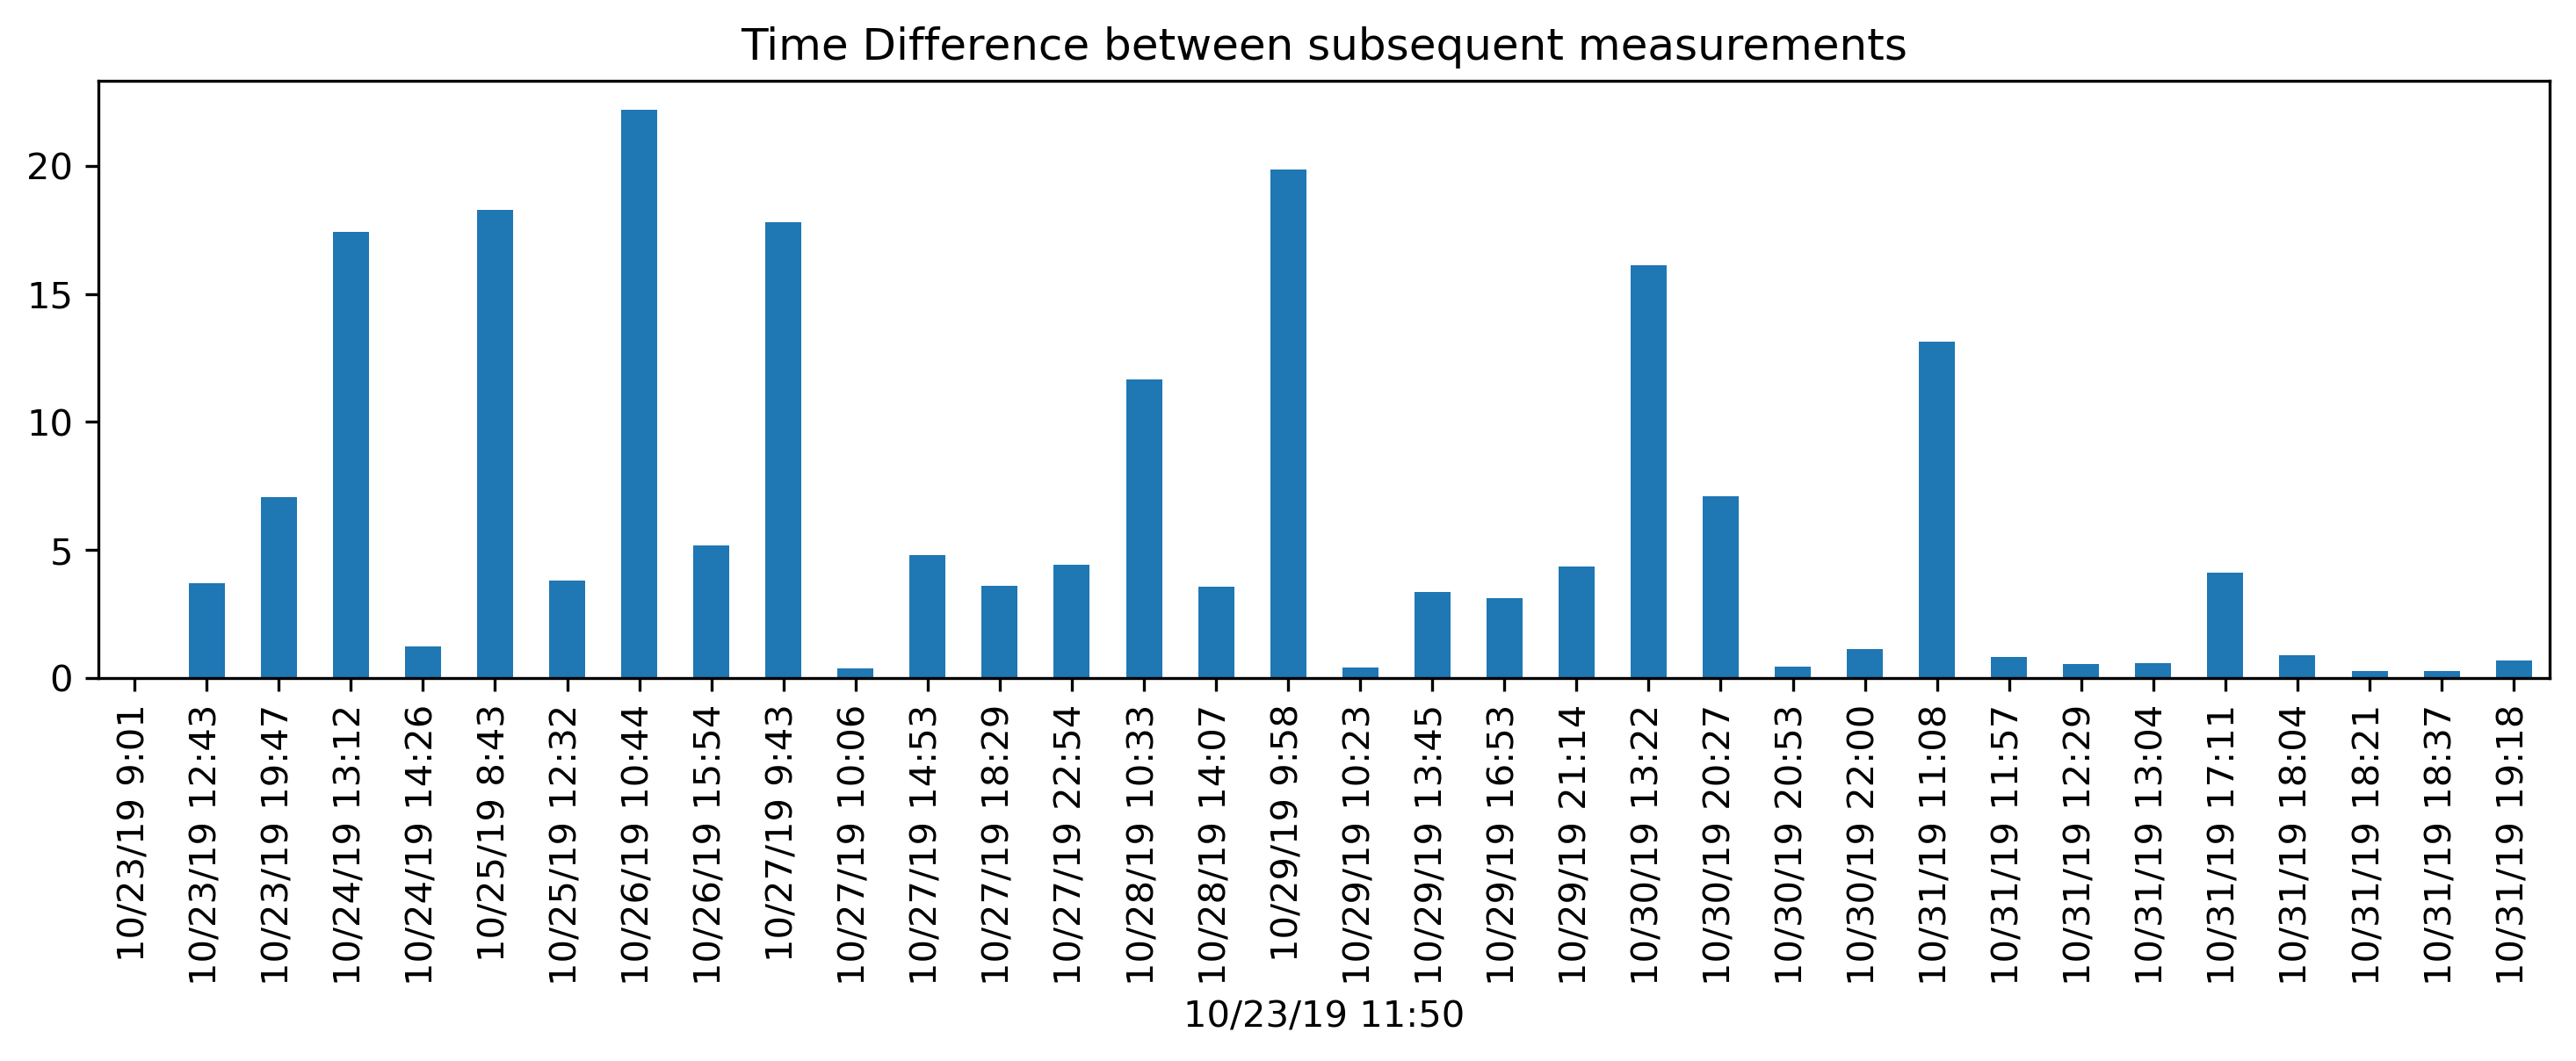

In [26]:
y, X = SYMPTOM_STATES["1.0"], cdf

X["time"] = X.index
X["time"] = pd.to_datetime(X["time"])

X = X.sort_values("time")

td = pd.to_datetime(X["time"][1:]).reset_index()["time"] - \
    pd.to_datetime(X["time"][:-1]).reset_index()["time"]

X["time_diff_hours"] = None

X["time_diff_hours"][1:] = td.apply(lambda x: x.total_seconds()/3600)

plt.figure(figsize=(12,3), dpi=300)
X["time_diff_hours"].plot(kind="bar")
plt.title("Time Difference between subsequent measurements")

Text(0.5, 1.0, 'Time Difference between subsequent measurements\n blue=low symptom, red = high symptom')

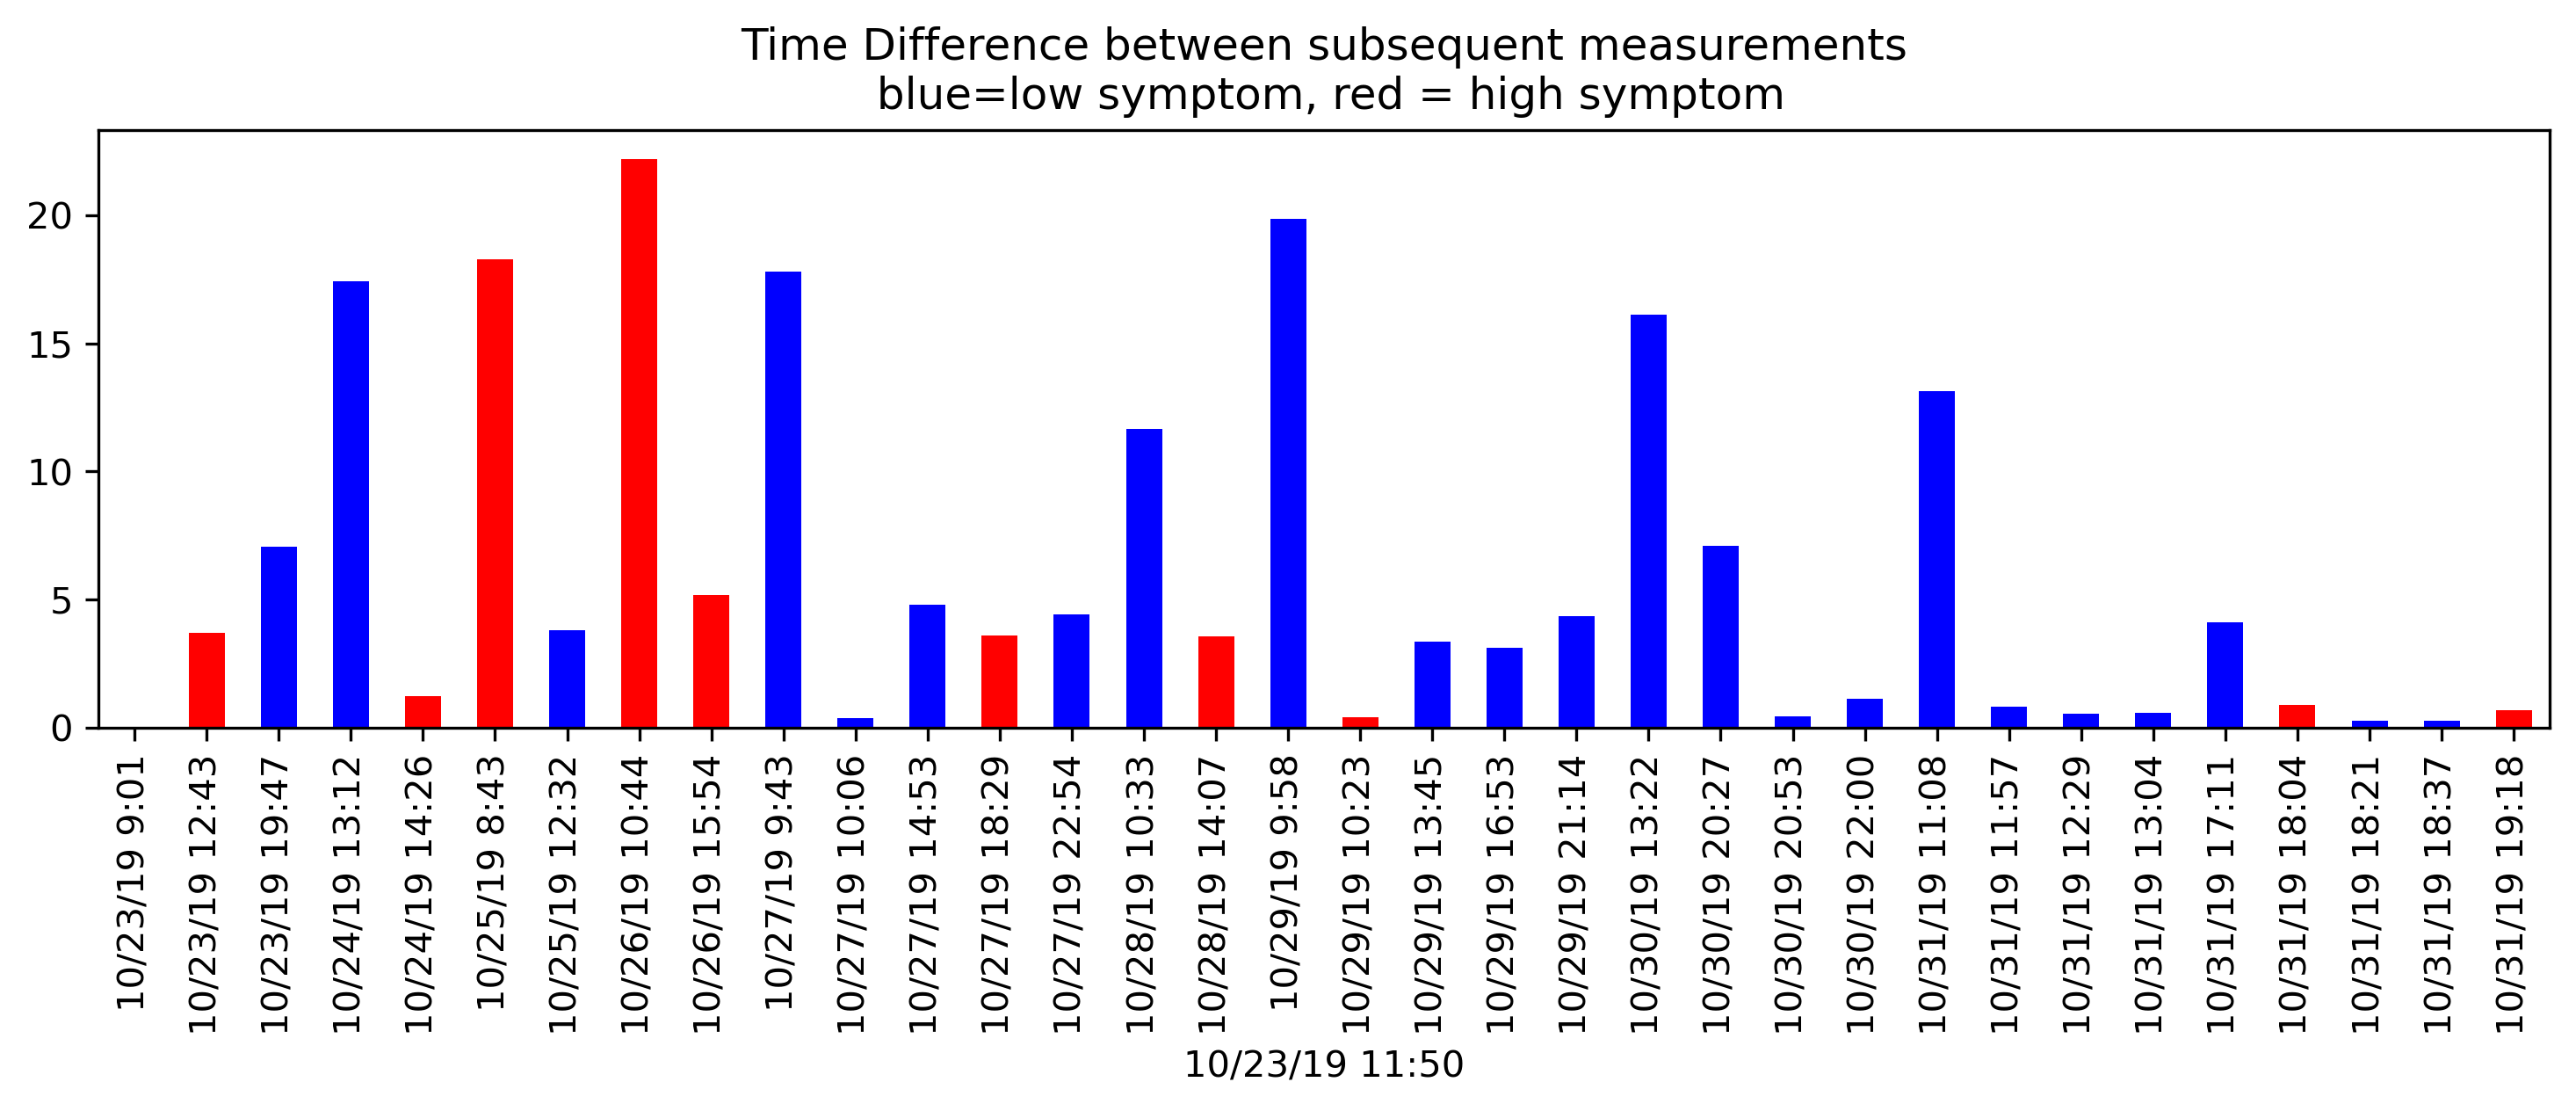

In [27]:
plt.figure(figsize=(12,3), dpi=300)
X["time_diff_hours"].plot.bar(color=y[1:].apply(lambda y: "blue" if y==0 else "red"))
plt.title("Time Difference between subsequent measurements\n blue=low symptom, red = high symptom")

### most high symptom states are in the beginning

### check if classes are balanced?

In [10]:
y, X = SYMPTOM_STATES["1.0"], cdf

In [11]:
y.shape

(34,)

In [12]:
y.sum()

11.0

### How many brain regions were measured?

In [31]:
brain_areas = np.unique([i.split('_')[0] for i in list(X.columns) if "time" not in i])
brain_areas

array(['LA1', 'LA2', 'LA3', 'LA4', 'LA5', 'LH1', 'LH2', 'LH3', 'LH4',
       'LH5', 'LOFC1', 'LOFC2', 'LOFC6', 'LOFC7', 'LOFC8', 'LSGC2',
       'LSGC3', 'LSGC4', 'LVC1', 'LVC2', 'LVC3', 'RA1', 'RA2', 'RA3',
       'RA4', 'RA5', 'RH3', 'RH4', 'RH5', 'ROFC1', 'ROFC2', 'ROFC3',
       'ROFC5', 'ROFC6', 'RSGC3', 'RSGC4', 'RSGC5', 'RSGC6', 'RVC1',
       'RVC2', 'RVC3'], dtype='<U5')

### How many frequency bands?

In [14]:
np.unique([i.split('_')[1] for i in list(X.columns) if "time" not in i])

array(['alpha', 'beta', 'delta', 'gamma', 'theta'], dtype='<U5')

### How are features correlated for a single area?

<AxesSubplot:>

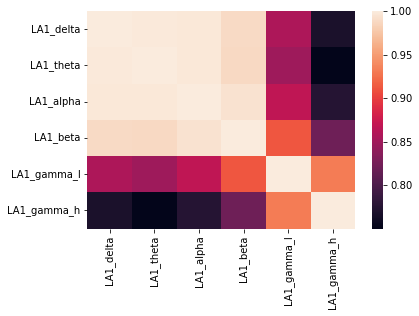

In [15]:
features_ = X[[i for i in list(X.columns) if "LA1" in i]]

corr = features_.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Distribution of features

<AxesSubplot:>

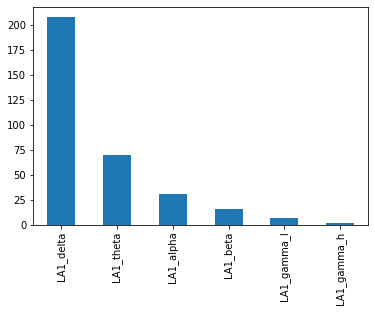

In [19]:
features_.mean(axis=0).plot(kind="bar")

#### Normalize data

In [22]:
from scipy import stats

features_ = stats.zscore(features_, axis=0)

### plot features over time

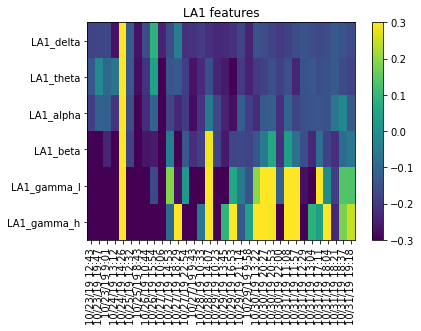

In [24]:
plt.imshow(features_.T, aspect='auto')
plt.clim(-0.3, 0.3)
plt.yticks(range(len(features_.columns)), features_.columns)
plt.xticks(range(len(features_.index)), features_.index, rotation=90)
plt.title("LA1 features")
plt.colorbar()
plt.show()

### check if PCA can perform a meaningful dimensionality reduction

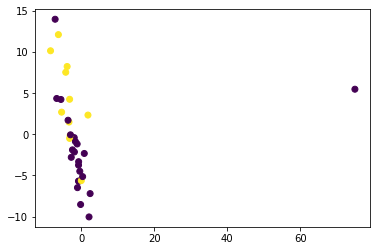

In [29]:
from sklearn import decomposition

features_all = X.loc[:, (X.columns != "time") & (X.columns != "time_diff_hours")]
features_all = stats.zscore(features_all, axis=0)

pca_ = decomposition.PCA(n_components=2)
pca_.fit(features_all)

features_pca = pca_.transform(features_all)

plt.scatter(features_pca[:,0], features_pca[:,1], c=y)

### Plot features separated by classes for each brain area

In [33]:
brain_areas = np.unique([i.split('_')[0] for i in list(X.columns) if "time" not in i])

In [35]:
features_all = X.loc[:, (X.columns != "time") & (X.columns != "time_diff_hours")]
features_all = stats.zscore(features_all, axis=0)

In [ ]:
def get_sb_df(df_region):
    df_high = pd.melt(df_region[y==0])
    df_high["depression_state"] = 0
    df_low = pd.melt(df_region[y==1])
    df_low["depression_state"] = 1
    return pd.concat([df_high, df_low])

plt.figure(figsize=(30, 40), dpi=200)
for idx, brain_area in enumerate(brain_areas):
    plt.subplot(10,5, idx+1)
    df_sns = get_sb_df(features_all[[i for i in list(features_all.columns) if brain_area in i]])
    sns.boxplot(data=df_sns, x="variable", y="value", hue="depression_state", palette="viridis")
    plt.xticks(rotation=90)
    plt.ylim(-2,2)
    plt.title(brain_area)

plt.tight_layout()
plt.show()

C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Se

C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_low = pd.melt(df_region[y==1])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_high = pd.melt(df_region[y==0])
C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24192/906015268.py:4: UserWarning: Boolean Se

### REDO analysis within CV

In [260]:
X, y = cdf, SYMPTOM_STATES["1.0"]
n_feats=6
n_ite=200
n_splits=2

In [261]:
X = X.apply(zscore)

In [279]:
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
scores = list()
scores_shuffled = list()    
top_feats = list()
accuracy = list()
accuracy_shuffled = list()
df_roc = list()
df_roc_shuffled = list()
conf_matrix_ = list()
f1_score = list()
for iii in range(n_ite):
    for train_idx, test_idx in kfold.split(X, y):
        pipe = Pipeline([('norm', StandardScaler()),
                         ('fselect', SelectKBest(score_func=f_classif, k=n_feats)), 
                         ('logit', LogisticRegression(class_weight='balanced', solver='lbfgs'))]) 
        pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
        probas = pipe.predict_proba(X.iloc[test_idx])
        preds = pipe.predict(X.iloc[test_idx])
        accuracy.append(accuracy_score(y.iloc[test_idx], preds))
        accuracy_shuffled.append(accuracy_score(y.iloc[test_idx], np.random.permutation(preds)))
        scores.append(roc_auc_score(y.iloc[test_idx], probas[:, 1]))
        scores_shuffled.append(roc_auc_score(y.iloc[test_idx], np.random.permutation(probas[:, 1])))  
        top_feats.extend(X.columns[pipe.named_steps['fselect'].get_support(indices=True)])

        tpr, fpr, _ = roc_curve(y.iloc[test_idx], probas[:, 1])
        df_roc.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))

        tpr, fpr, _ = roc_curve(y.iloc[test_idx], np.random.permutation(probas[:, 1]))
        df_roc_shuffled.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))
        
        conf_matrix_.append(metrics.confusion_matrix(y_true=y.iloc[test_idx], y_pred=preds, normalize="true"))
        f1_score.append(metrics.f1_score(y_true=y.iloc[test_idx], y_pred=preds))
df_roc = pd.concat(df_roc)
df_roc_shuffled = pd.concat(df_roc_shuffled)  

In [264]:
np.mean(accuracy_shuffled)

0.5479411764705883

In [280]:
np.mean(f1_score)

0.6015640439711647

In [265]:
np.mean(accuracy)

0.7314705882352942

In [274]:
metrics.confusion_matrix?

In [277]:
np.array(conf_matrix_).mean(axis=0)

array([[0.77212121, 0.22787879],
       [0.37175   , 0.62825   ]])

### check for class balance

In [26]:
y, X = SYMPTOM_STATES["1.0"], cdf

In [30]:
y.shape

(34,)

In [29]:
y.sum()

11.0

In [28]:
X.shape

(34, 246)

In [80]:
X["time"] = X.index
X["time"] = pd.to_datetime(X["time"])

X = X.sort_values("time")

td = pd.to_datetime(X["time"][1:]).reset_index()["time"] - \
    pd.to_datetime(X["time"][:-1]).reset_index()["time"]

X["time_diff_hours"] = None

X["time_diff_hours"][1:] = td.apply(lambda x: x.total_seconds()/3600)

plt.figure(figsize=(12,3), dpi=300)
X["time_diff_hours"].plot(kind="bar")
plt.title("Time Difference between subsequent measurements")

C:\Users\ICN_AD~1\AppData\Local\Temp/ipykernel_24460/217959136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time_diff_hours"][1:] = td.apply(lambda x: x.total_seconds()/3600)


Text(0.5, 1.0, 'Time Difference between subsequent measurements')

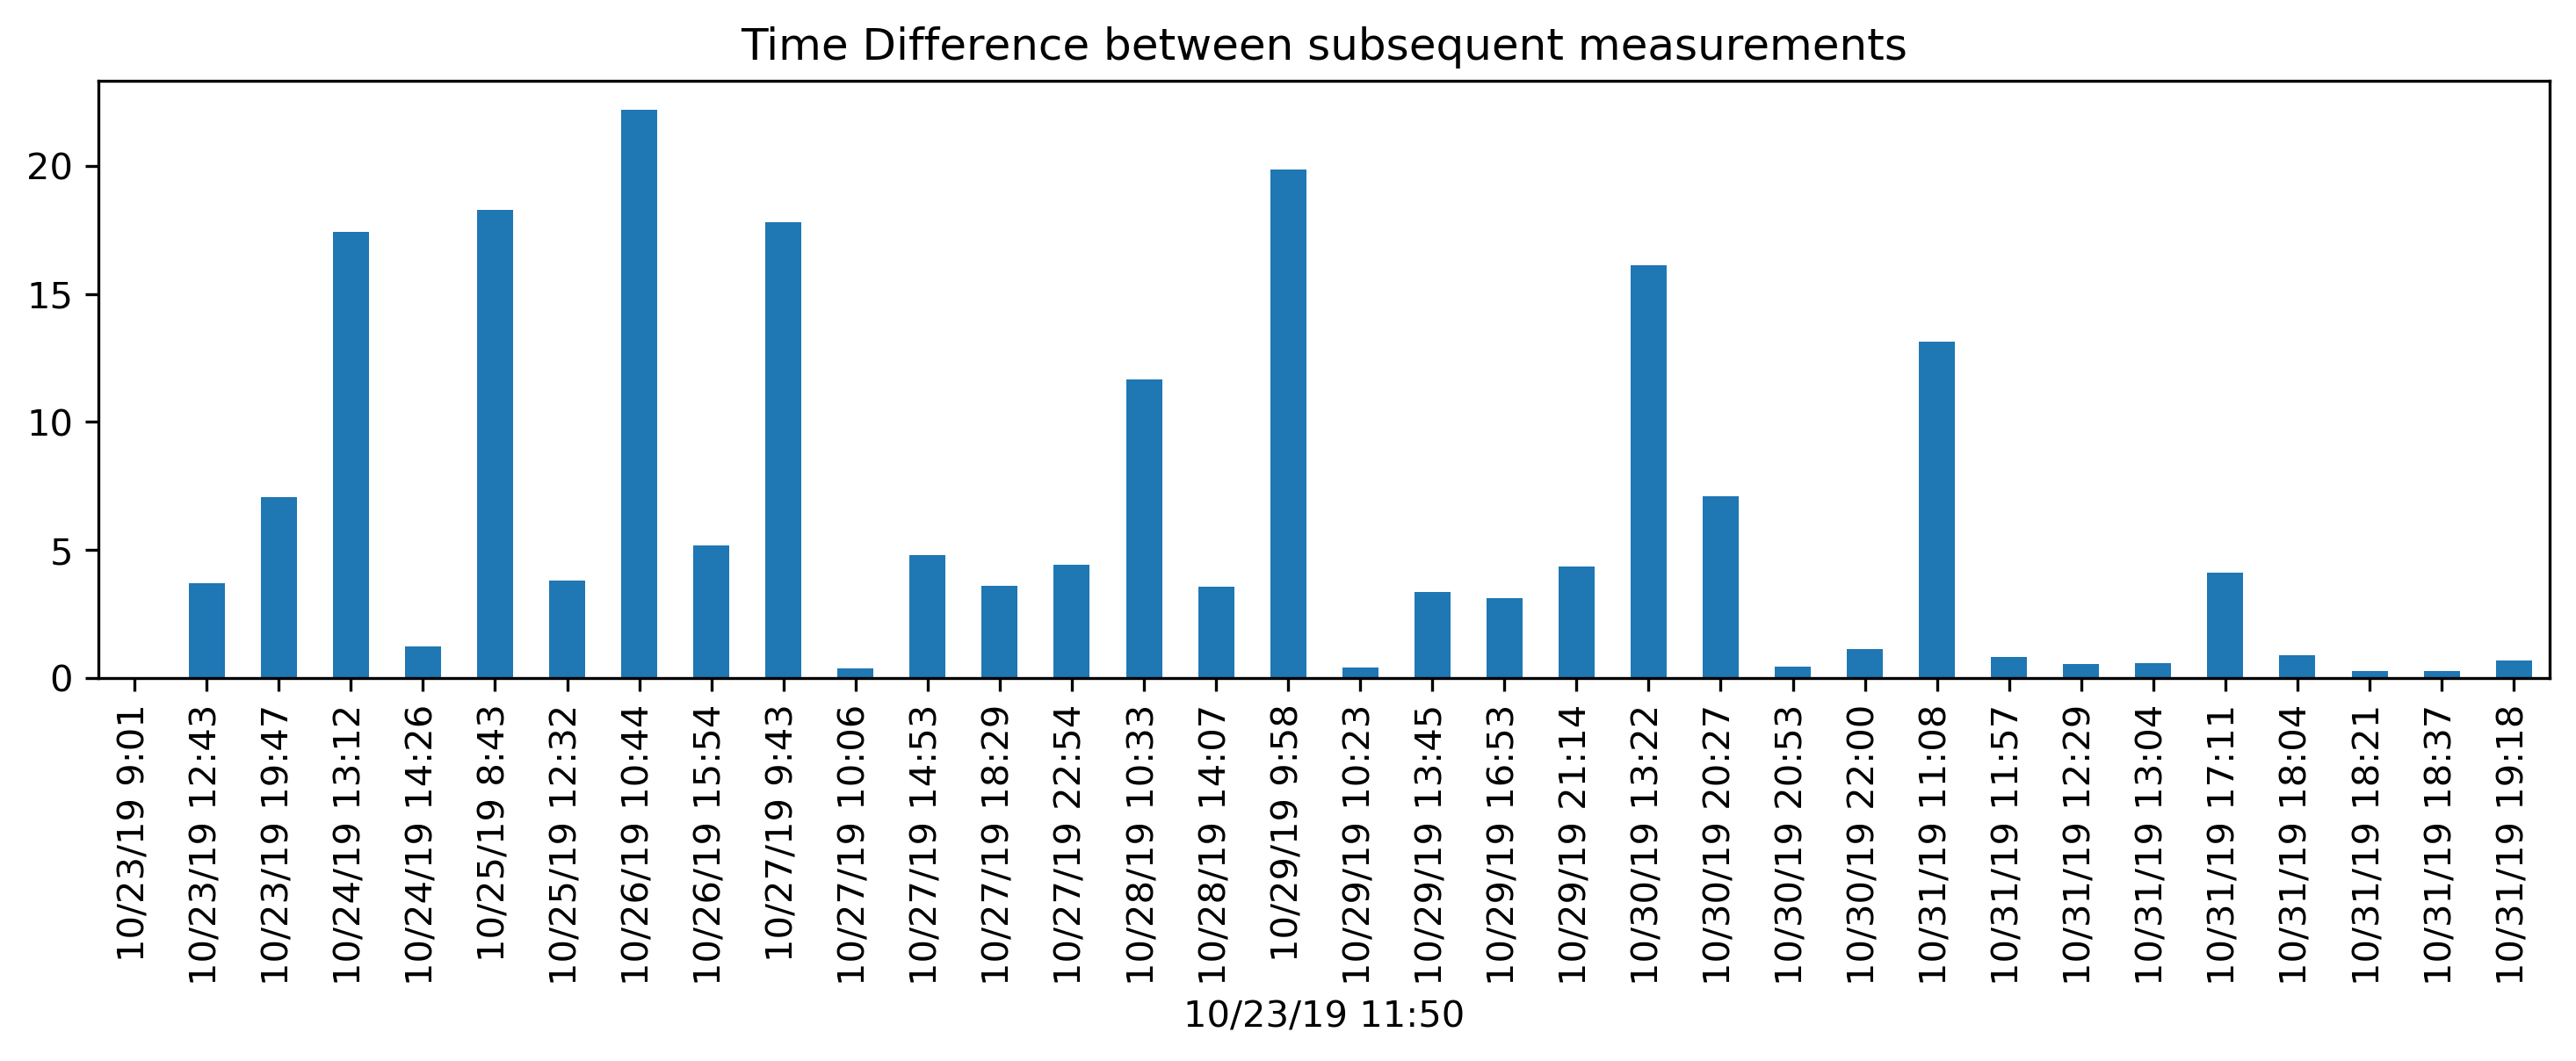

### How many brain regions were measured?

In [138]:
np.unique([i.split('_')[0] for i in list(X.columns) if "time" not in i])

array(['LA1', 'LA2', 'LA3', 'LA4', 'LA5', 'LH1', 'LH2', 'LH3', 'LH4',
       'LH5', 'LOFC1', 'LOFC2', 'LOFC6', 'LOFC7', 'LOFC8', 'LSGC2',
       'LSGC3', 'LSGC4', 'LVC1', 'LVC2', 'LVC3', 'RA1', 'RA2', 'RA3',
       'RA4', 'RA5', 'RH3', 'RH4', 'RH5', 'ROFC1', 'ROFC2', 'ROFC3',
       'ROFC5', 'ROFC6', 'RSGC3', 'RSGC4', 'RSGC5', 'RSGC6', 'RVC1',
       'RVC2', 'RVC3'], dtype='<U5')

### How many frequency bands?

In [139]:
np.unique([i.split('_')[1] for i in list(X.columns) if "time" not in i])

array(['alpha', 'beta', 'delta', 'gamma', 'theta'], dtype='<U5')

### How are features correlated for a single area?

In [145]:
features_ = X[[i for i in list(X.columns) if "LA1" in i]]

<AxesSubplot:>

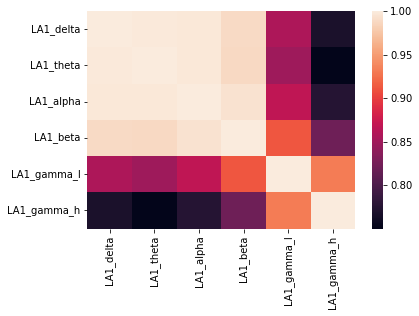

In [147]:
features_ = X[[i for i in list(X.columns) if "LA1" in i]]

corr = features_.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [152]:
features_.describe()

,LA1_delta,LA1_theta,LA1_alpha,LA1_beta,LA1_gamma_l,LA1_gamma_h
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,207.284998,69.803950,30.960053,15.139609,6.385351,1.631085
std,152.438027,35.750789,13.132551,4.757558,1.057123,0.309165
min,166.578837,59.168491,26.299636,13.258270,5.035225,1.181542
25%,175.486896,61.871221,28.166545,13.962976,5.950113,1.467360
50%,181.456015,64.184227,28.832539,14.295898,6.223282,1.607813
75%,183.735078,64.940348,29.404744,14.736000,6.569052,1.722107
max,1068.275604,271.599583,105.094812,41.821725,11.495342,2.969414


### Data is not normalized

<AxesSubplot:>

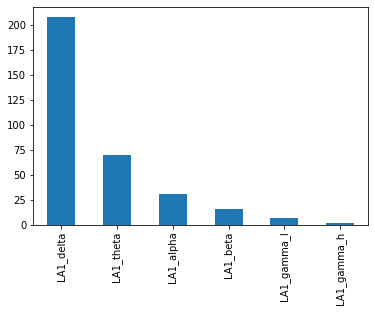

In [154]:
features_.mean(axis=0).plot(kind="bar")

### Normalize data and check zscored features over time

In [161]:
from scipy import stats

features_ = stats.zscore(features_, axis=0)

In [168]:
features_["LA1_beta"].var()

1.0303030303030303

In [173]:
features_

,LA1_delta,LA1_theta,LA1_alpha,LA1_beta,LA1_gamma_l,LA1_gamma_h
10/23/19 11:50,,,,,,
10/23/19 9:01,-0.169525,-0.097525,-0.118892,-0.237297,-0.750337,-0.915794
10/23/19 12:43,-0.176140,-0.138594,-0.191793,-0.297077,-0.605890,-0.775156
10/23/19 19:47,-0.174450,-0.013011,-0.112808,-0.355758,-1.296377,-1.475927
10/24/19 13:12,-0.270131,-0.069525,-0.210595,-0.401389,-1.138395,-1.333931
10/24/19 14:26,5.733074,5.729393,5.730008,5.692705,4.906560,4.393954
10/25/19 8:43,-0.271050,-0.277432,-0.310482,-0.380330,-0.866276,-1.206435
10/25/19 12:32,-0.125333,-0.137919,-0.157356,-0.183707,-0.399019,-0.456414
10/26/19 10:44,-0.161520,-0.212449,-0.224531,-0.264728,-0.512187,-0.403271
10/26/19 15:54,0.088819,0.045033,-0.111231,-0.257460,-0.168136,-0.857844


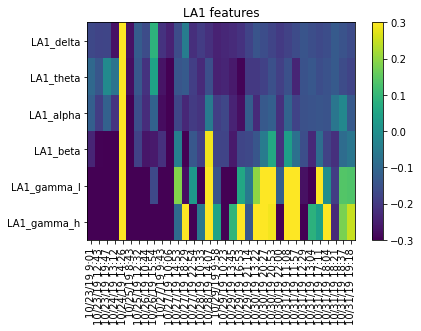

In [179]:
plt.imshow(features_.T, aspect='auto')
plt.clim(-0.3, 0.3)
plt.yticks(range(len(features_.columns)), features_.columns)
plt.xticks(range(len(features_.index)), features_.index, rotation=90)
plt.title("LA1 features")
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Time Difference between subsequent measurements\n blue=low symptom, red = high symptom')

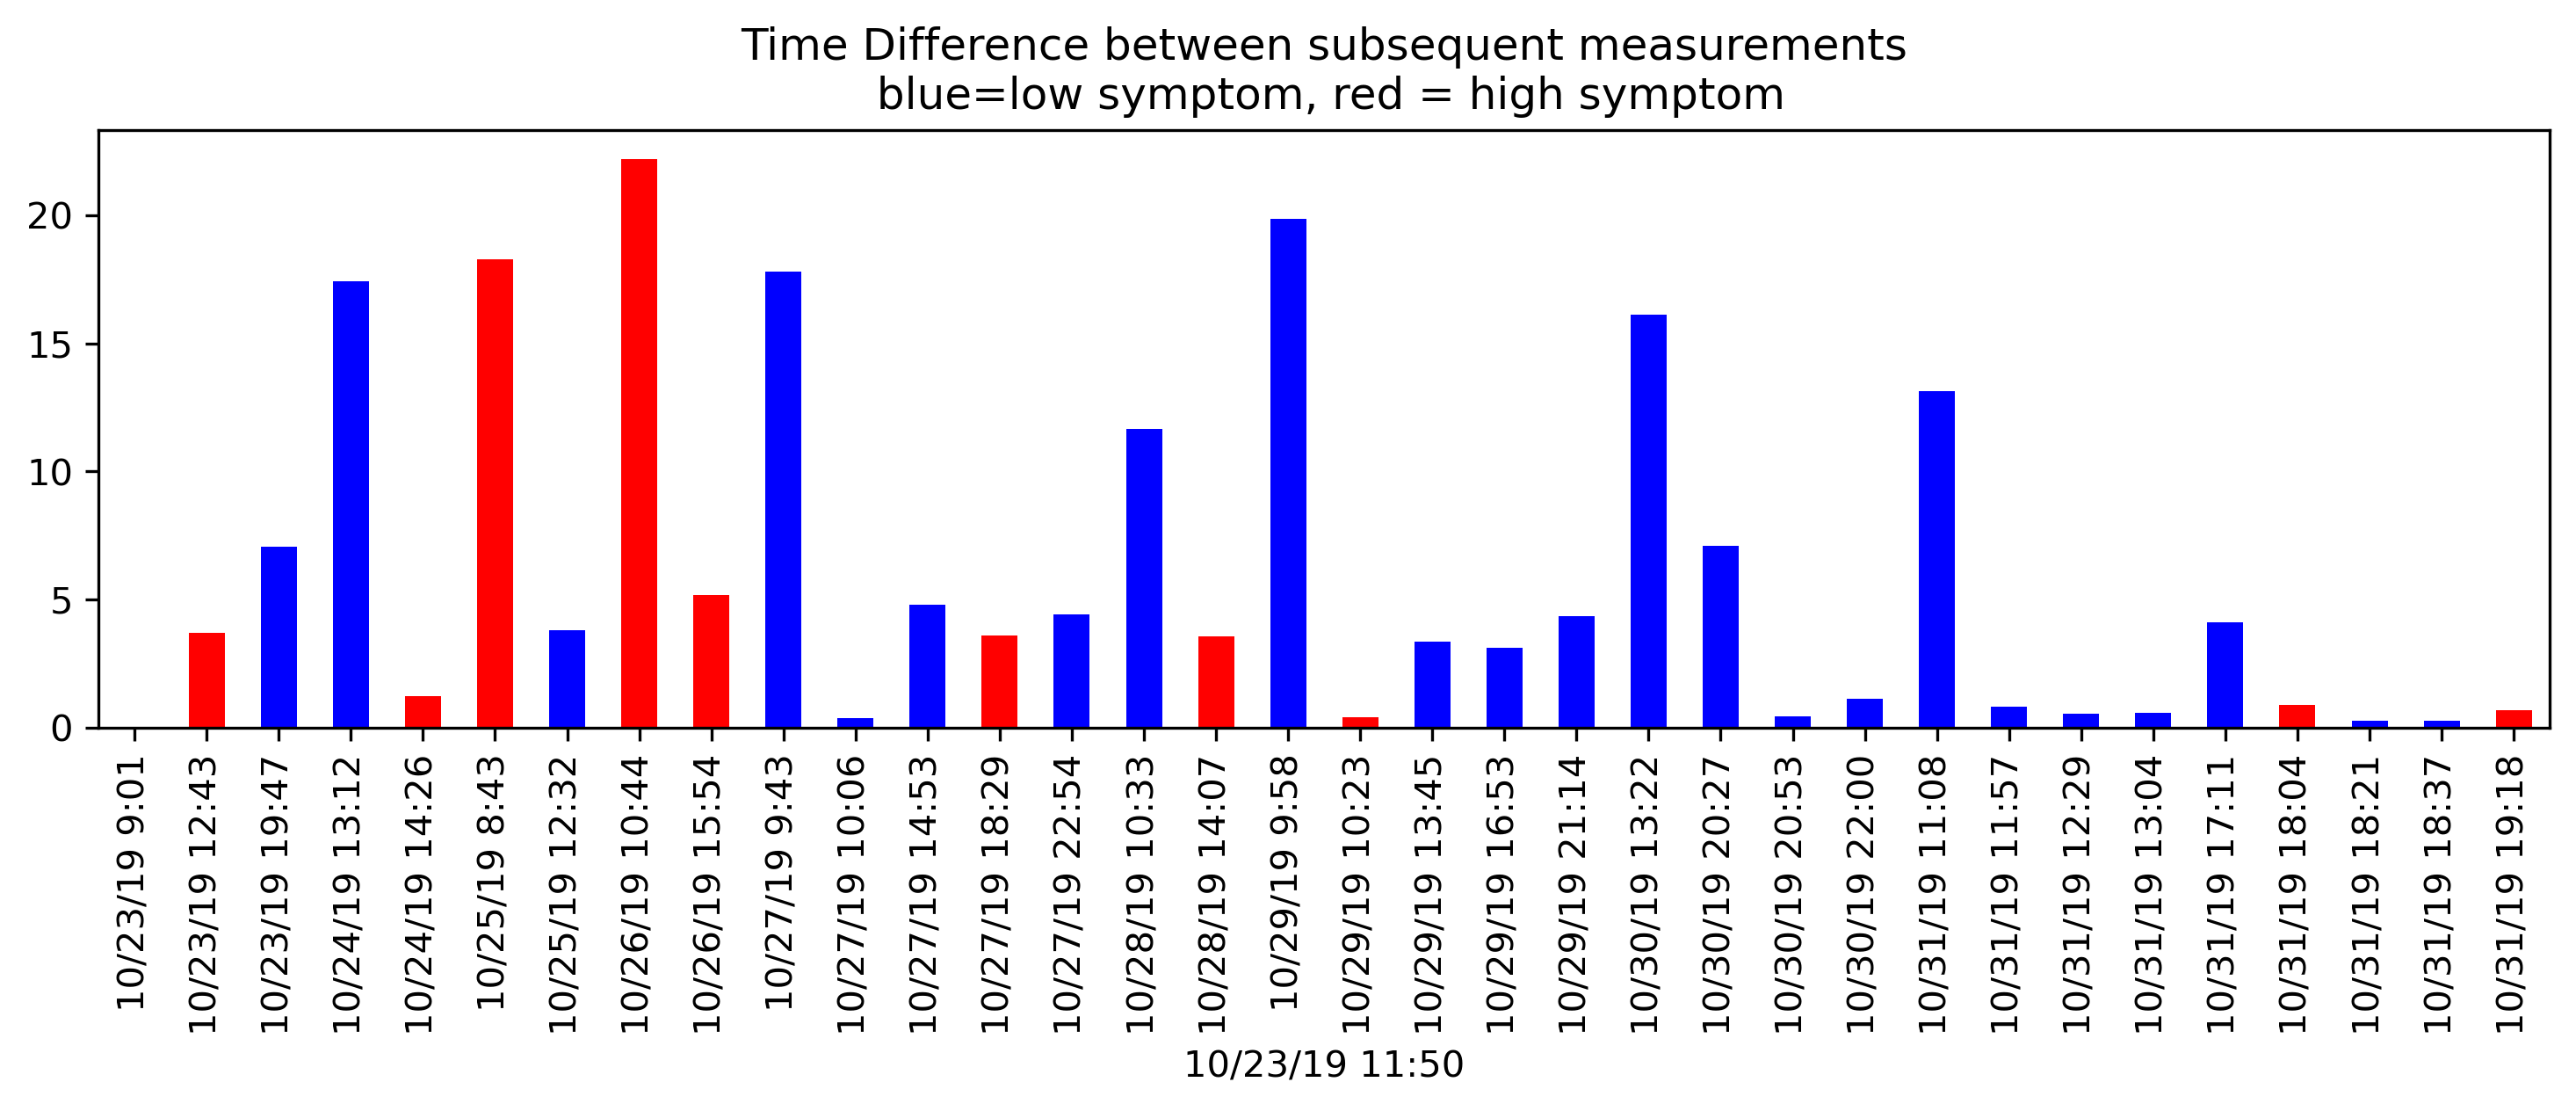

In [194]:
plt.figure(figsize=(12,3), dpi=300)
X["time_diff_hours"].plot.bar(color=y[1:].apply(lambda y: "blue" if y==0 else "red"))
plt.title("Time Difference between subsequent measurements\n blue=low symptom, red = high symptom")

### Check how well PCA can differentiate the classes

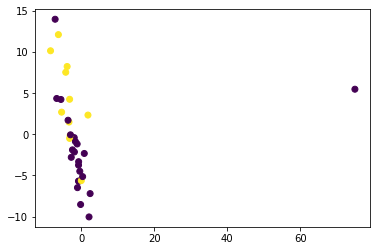

In [28]:
from sklearn import decomposition

features_all = X.loc[:, (X.columns != "time") & (X.columns != "time_diff_hours")]
features_all = stats.zscore(features_all, axis=0)

pca_ = decomposition.PCA(n_components=2)
pca_.fit(features_all)

features_pca = pca_.transform(features_all)

plt.scatter(features_pca[:,0], features_pca[:,1], c=y)

In [213]:
features_all["LA1_delta"].mean()

-1.2898179256674614e-16

PCA(n_components=2)

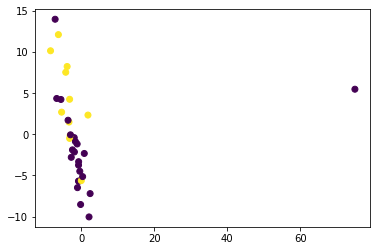

### there seems to be one outlier

In [224]:
np.where(features_pca[:,0]>60)

(array([4], dtype=int64),)

In [226]:
features_all = features_all.drop(features_all.index[[4]])

In [227]:
pca_ = decomposition.PCA(n_components=2)
pca_.fit(features_all)

PCA(n_components=2)

In [228]:
features_pca = pca_.transform(features_all)

In [233]:
y_delete_outlier = np.delete(np.array(y), (4), axis=0)

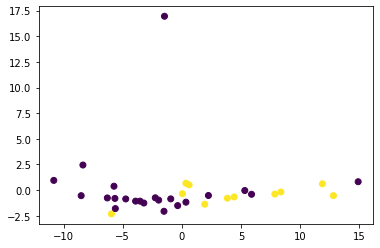

In [234]:
plt.scatter(features_pca[:,0], features_pca[:,1], c=y_delete_outlier)

### Mhhh, still an outlier

In [235]:
features_all = X.loc[:, (X.columns != "time") & (X.columns != "time_diff_hours")]
features_all = stats.zscore(features_all, axis=0)

In [237]:
import xgboost

In [238]:
clf = xgboost.XGBClassifier()

In [507]:
from sklearn import model_selection, metrics, discriminant_analysis, linear_model, svm, ensemble

In [420]:
selector = SelectKBest(score_func=f_classif, k=n_feats)

In [424]:
n_feats

6

In [445]:
X_train["LA1_gamma_l"].std()

1.0307764064044151

In [537]:
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE, ADASYN

In [539]:
y_train.sum()

5.0

In [540]:
y_train.shape

(17,)

In [541]:
ADASYN?

In [556]:
SMOTE?

In [565]:

ros = RandomOverSampler(random_state=0)
smote = SMOTE()


n_splits = 2
n_ite = 20
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
accuracy = list()
scores = list()
auc_ = list()
conf_matrix_ = []
f1_score = []
n_feats = 20

data = X[[i for i in list(X.columns) if "gamma" in i]]

for idx in range(n_ite):
    for train_idx, test_idx in kfold.split(data, y):
        
        X_train, y_train = data.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = data.iloc[test_idx], y.iloc[test_idx]
        
        selector = SelectKBest(score_func=f_classif, k=n_feats)
        X_train_sel = selector.fit_transform(X_train, y_train)
        X_test_sel = X_test[selector.get_feature_names_out()]
        
        #X_train_sel = stats.zscore(X_train_sel)
        #X_test_sel = stats.zscore(X_test_sel)
        
        #X_train_sel, y_train = ros.fit_resample(X_train_sel, y_train)
        #X_train_sel, y_train = SMOTE(k_neighbors=4).fit_resample(X_train_sel, y_train)
        
        clf = linear_model.LogisticRegression(class_weight="balanced")
        #clf = svm.SVC(class_weight="balanced")
        #clf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced")
        
        #clf = discriminant_analysis.LinearDiscriminantAnalysis()
        
        clf.fit(X_train_sel, y_train)

        #clf.predict_proba(X_test_sel)
        preds = clf.predict(X_test_sel)

        accuracy.append(accuracy_score(y_test, preds))
        auc_.append(metrics.roc_auc_score(y_test, preds))
        conf_matrix_.append(metrics.confusion_matrix(y_true=y_test, y_pred=preds, normalize="true"))
        f1_score.append(metrics.f1_score(y_true=y_test, y_pred=preds))

C:\Users\ICN_admin\Anaconda3\envs\pyneuromodulation\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ICN_admin\Anaconda3\envs\pyneuromodulation\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ICN_admin\Anaconda3\envs\pyneuromodulation\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ICN_admin\Anaconda3\envs\pyneuromodulation\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\ICN_admin\Anaconda3\envs\pyneuromodulation\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\I

In [566]:
X_test.shape

(17, 82)

In [567]:
np.mean(auc_)

0.7424431818181818

In [568]:
np.mean(conf_matrix_, axis=0)

array([[0.79905303, 0.20094697],
       [0.31416667, 0.68583333]])

In [561]:
np.mean(f1_score)

0.517932276057276

### Visualize features by brain areas

In [289]:
brain_areas = np.unique([i.split('_')[0] for i in list(X.columns) if "time" not in i])

In [290]:
brain_areas

array(['LA1', 'LA2', 'LA3', 'LA4', 'LA5', 'LH1', 'LH2', 'LH3', 'LH4',
       'LH5', 'LOFC1', 'LOFC2', 'LOFC6', 'LOFC7', 'LOFC8', 'LSGC2',
       'LSGC3', 'LSGC4', 'LVC1', 'LVC2', 'LVC3', 'RA1', 'RA2', 'RA3',
       'RA4', 'RA5', 'RH3', 'RH4', 'RH5', 'ROFC1', 'ROFC2', 'ROFC3',
       'ROFC5', 'ROFC6', 'RSGC3', 'RSGC4', 'RSGC5', 'RSGC6', 'RVC1',
       'RVC2', 'RVC3'], dtype='<U5')

In [291]:
# make boxplot per brain area and show difference in features

In [292]:
X[[i for i in list(X.columns) if "LA1" in i]]

,LA1_delta,LA1_theta,LA1_alpha,LA1_beta,LA1_gamma_l,LA1_gamma_h
10/23/19 11:50,,,,,,
10/23/19 12:43,-0.176140,-0.138594,-0.191793,-0.297077,-0.605890,-0.775156
10/23/19 19:47,-0.174450,-0.013011,-0.112808,-0.355758,-1.296377,-1.475927
10/23/19 9:01,-0.169525,-0.097525,-0.118892,-0.237297,-0.750337,-0.915794
10/24/19 13:12,-0.270131,-0.069525,-0.210595,-0.401389,-1.138395,-1.333931
10/24/19 14:26,5.733074,5.729393,5.730008,5.692705,4.906560,4.393954
10/25/19 12:32,-0.125333,-0.137919,-0.157356,-0.183707,-0.399019,-0.456414
10/25/19 8:43,-0.271050,-0.277432,-0.310482,-0.380330,-0.866276,-1.206435
10/26/19 10:44,-0.161520,-0.212449,-0.224531,-0.264728,-0.512187,-0.403271
10/26/19 15:54,0.088819,0.045033,-0.111231,-0.257460,-0.168136,-0.857844


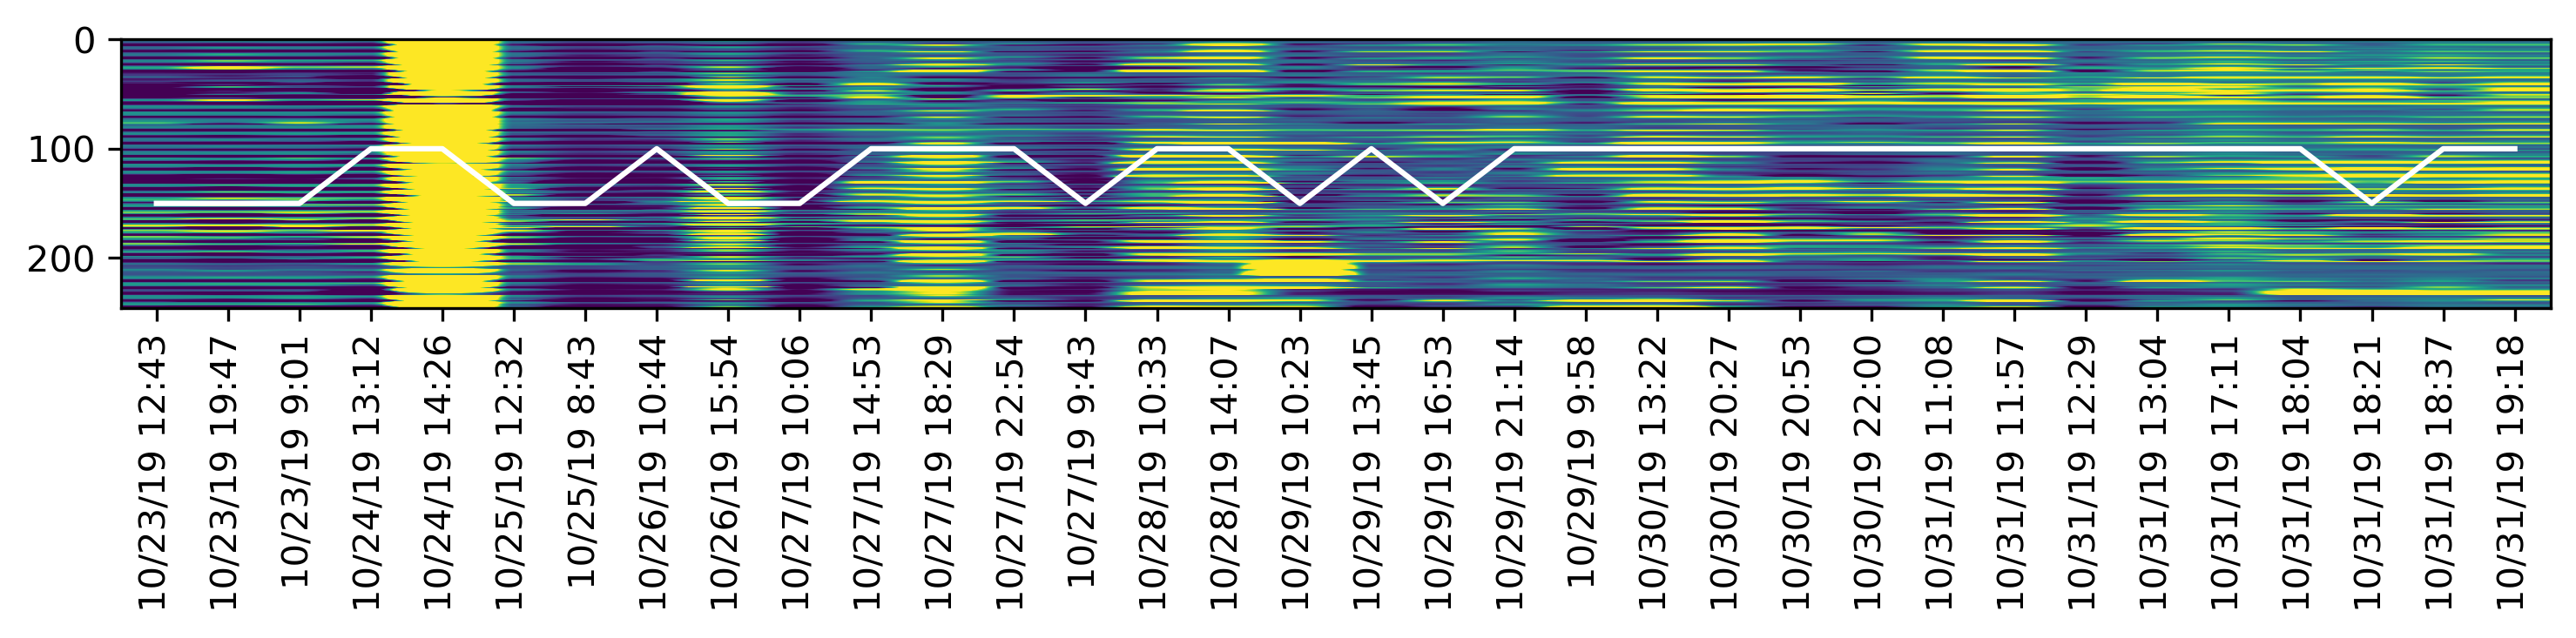

In [325]:

plt.figure(figsize=(12,3), dpi=300)
plt.subplot(211)
plt.imshow(X.T, aspect="auto")
plt.clim(-.5,.5)
#plt.colorbar()

#plt.subplot(212)
plt.plot(50*y+100, color="white")
plt.xticks(rotation=90)
plt.show()

In [386]:
brain_areas.shape

(41,)

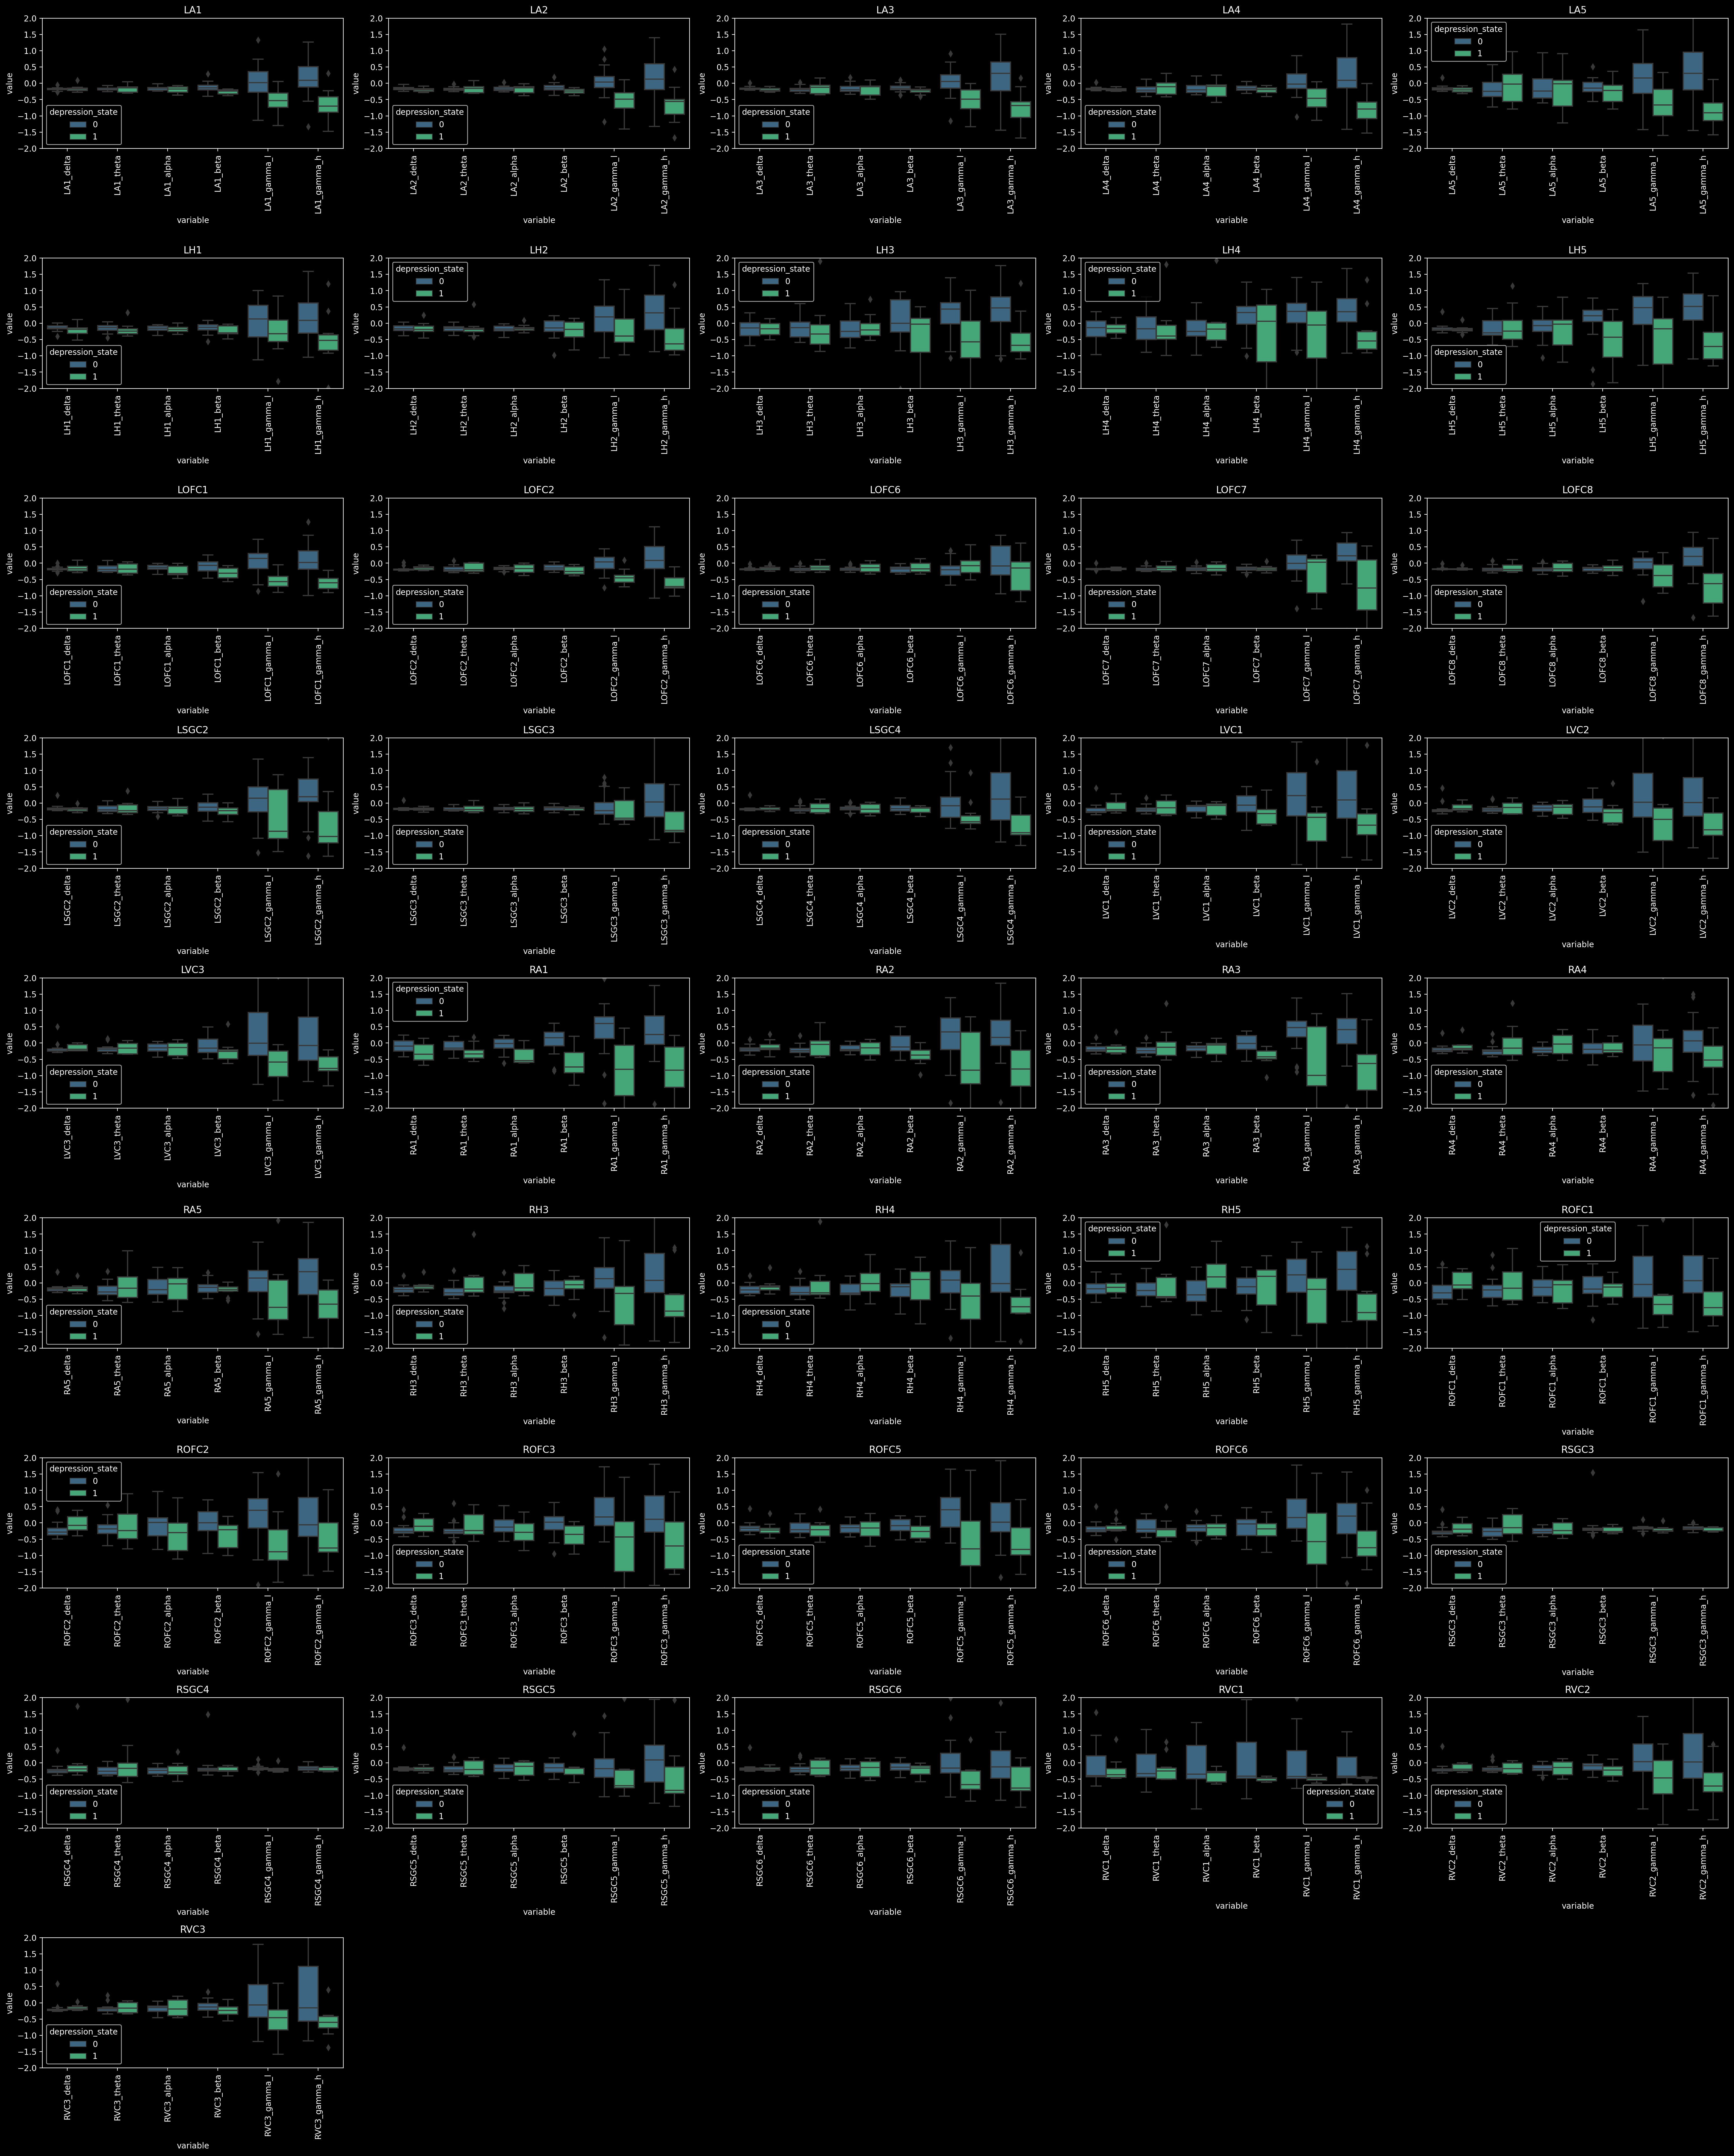

In [392]:
def get_sb_df(df_region):
    df_high = pd.melt(df_region[y==0])
    df_high["depression_state"] = 0
    df_low = pd.melt(df_region[y==1])
    df_low["depression_state"] = 1
    return pd.concat([df_high, df_low])

plt.figure(figsize=(30, 40), dpi=200)
for idx, brain_area in enumerate(brain_areas):
    plt.subplot(10,5, idx+1)
    df_sns = get_sb_df(X[[i for i in list(X.columns) if brain_area in i]])
    sns.boxplot(data=df_sns, x="variable", y="value", hue="depression_state", palette="viridis")
    plt.xticks(rotation=90)
    plt.ylim(-2,2)
    plt.title(brain_area)

plt.tight_layout()
plt.show()

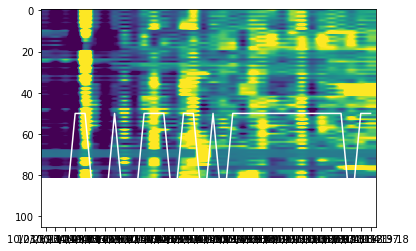

In [358]:
plt.imshow(X[[i for i in list(X.columns) if "gamma" in i]].T, aspect="auto")
plt.clim(-1, 1)
plt.plot(50*y+50, color="white")
plt.show()

In [359]:
PABS_FEAT = pd.read_csv(os.path.join(SRC_DATA_DIR, PR01_STAGEI_PABS_FEATS_FN), index_col=0)

In [368]:
PABS_FEAT[['anx', 'nrg', 'dpr', 'ham']].shape

(54, 4)

In [370]:
PABS_FEAT_c = PABS_FEAT.loc[SYMPTOM_STATES.index]

In [362]:
import umap

In [363]:
reducer_ = umap.UMAP()
embedding = reducer_.fit_transform(X)

In [364]:
embedding.shape

(34, 2)

In [381]:
scales = ['anx', 'nrg', 'dpr', 'ham']

In [382]:
for scale in scales:
    print(scale)

anx
nrg
dpr
ham


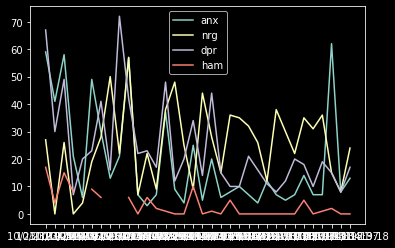

In [383]:
for scale in scales:
    plt.plot(PABS_FEAT_c[scale], label=scale)
plt.legend()


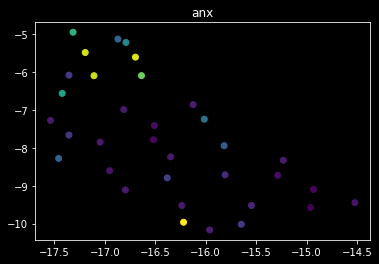

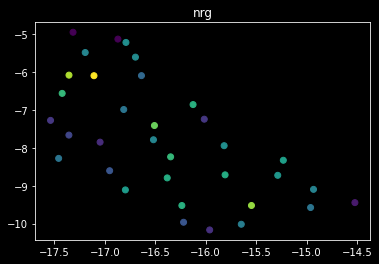

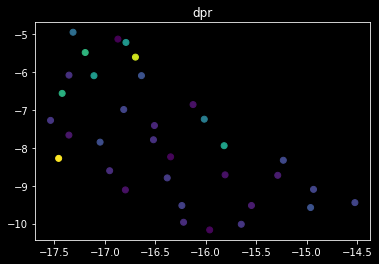

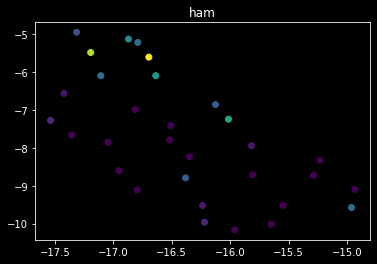

In [373]:
for scale in scales:
    plt.style.use('dark_background')
    plt.scatter(embedding[:,0], embedding[:,1], c=PABS_FEAT_c[scale])
    plt.title(scale)
    plt.style.use('dark_background')
    plt.show()

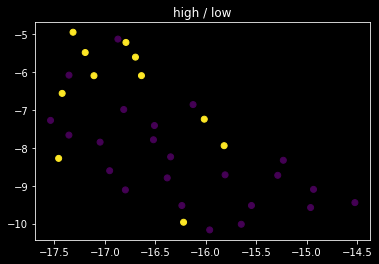

In [385]:
plt.style.use('dark_background')
plt.scatter(embedding[:,0], embedding[:,1], c=y)
plt.title("high / low")
plt.show()